# test the bridge code

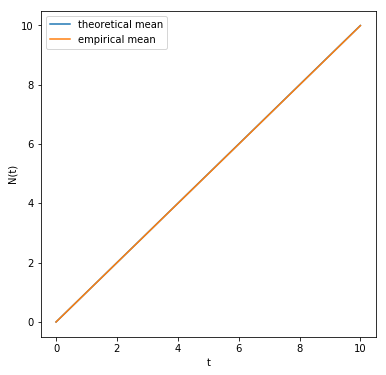

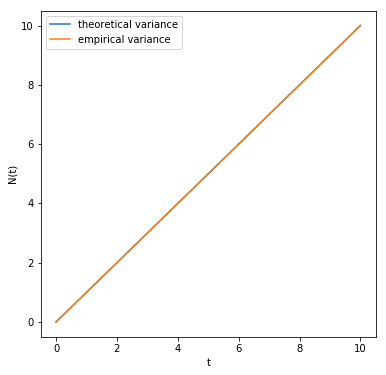

(slope, intercept, r): (1.0008201462990272, -0.00027540328944275494, 0.9999993750551134)


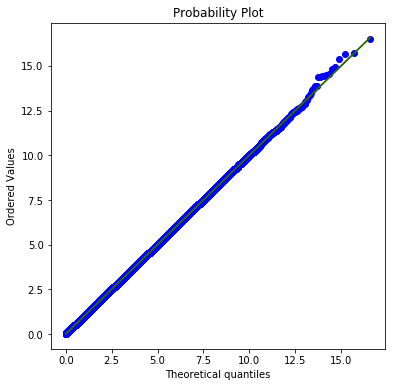

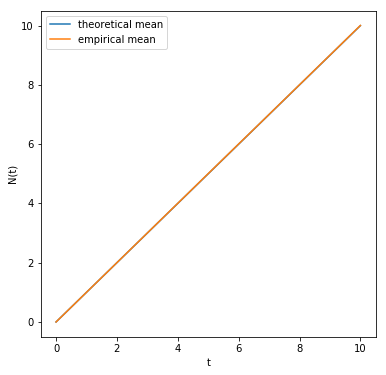

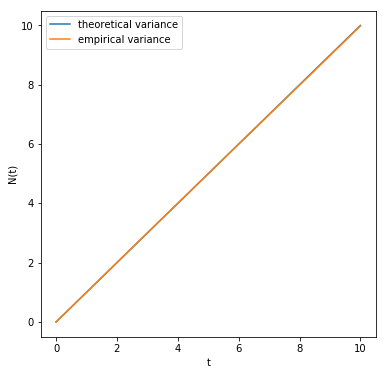

(slope, intercept, r): (0.9998234532970511, -0.00043309266514324207, 0.9999989334053845)


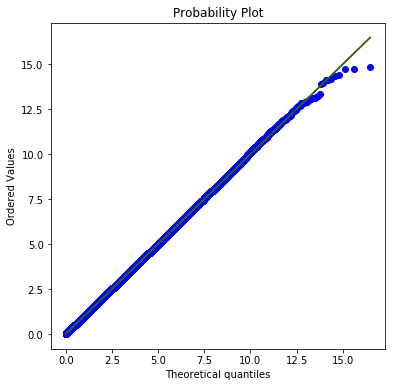

In [115]:
%matplotlib inline

from binomial_bridge import BinomialBridge
from beta_bridge import BetaBridge

import numpy as np
import scipy
import sobol_seq
import matplotlib.pyplot as plt

#jump_times_list is a list of jump time paths, where each element corresponds to a path
def plot_jump_times_stats(jump_times_list, T, is_beta_bridge):
    times_interp = np.linspace(0, T, 100+1)

    if is_beta_bridge:
        #need to create a different set of jump times, otherwise the interarrival times become biased
        #by filling in the rest of the jump times between jump_times[-1] and T
        #however, by doing so we get the right mean and expectation of the counting process
        jump_times_interp = []
        for jump_times in jump_times_list:
            if jump_times[-1] >= T:
                jump_times_interp.append(jump_times)
            else:
                dt = T - jump_times[-1]
                y = np.random.poisson(dt)
                if y > 0:
                    new_times = jump_times[-1] + np.sort(np.random.uniform(0, dt, size=y))
                    jump_times_interp.append(np.concatenate((jump_times, new_times)))
                else:
                    jump_times_interp.append(jump_times)
    else:
        jump_times_interp = jump_times_list
        
    counts = [range(1, len(jump_times)+1) for jump_times in jump_times_interp]  
    
    interp_functions = [scipy.interpolate.interp1d(jump_times, count, kind='previous', fill_value=(0, count[-1]), bounds_error=False)
                        if jump_times.size > 1 else lambda x: np.zeros(x.size) for jump_times,count in zip(jump_times_interp, counts)]

    interp_counts = [func(times_interp) for func in interp_functions]
    interp_counts = np.vstack(interp_counts)

    plt.figure(figsize=(6,6))
    plt.plot(times_interp, times_interp, label='theoretical mean')
    plt.plot(times_interp, np.mean(interp_counts, axis=0), label='empirical mean')
    plt.legend()
    plt.xlabel('t')
    plt.ylabel('N(t)')
    plt.show()

    plt.figure(figsize=(6,6))
    plt.plot(times_interp, times_interp, label='theoretical variance')
    plt.plot(times_interp, np.var(interp_counts, axis=0), label='empirical variance')
    plt.legend()
    plt.xlabel('t')
    plt.ylabel('N(t)')
    plt.show()

    plt.figure(figsize=(6,6))
    interarrival_times = [np.diff(jump_times, prepend=0) for jump_times in jump_times_list]
    interarrival_times = np.concatenate(interarrival_times)

    quantiles, line = scipy.stats.probplot(interarrival_times, dist='expon', plot=plt)
    print('(slope, intercept, r): {}'.format(line))
    x = np.linspace(0, quantiles[0][-1], 101)
    plt.plot(x,x, color='green')
    plt.show()

################################
# parameters for the tests
################################
n = 10**6
discretization_power = 3
dim = 2**discretization_power
    
T = Y_at_T = 10

# points = sobol_seq.i4_sobol_generate(dim, n).T

points = np.random.uniform(size=(dim, n))

################################
# test the binomial bridge
################################
binom_bridge = BinomialBridge(T, discretization_power, points)
binom_bridge.generate()
binom_bridge.fill_jump_times()

plot_jump_times_stats(binom_bridge.jump_times, T, False)

# ################################
# # test the beta bridge
# ################################
beta_bridge = BetaBridge(Y_at_T, discretization_power, points)
beta_bridge.generate()
beta_bridge.fill_jump_times()

plot_jump_times_stats(beta_bridge.jump_times, Y_at_T, True)

# Y_at_T = 10000
# gamma = np.random.gamma(Y_at_T, 1, size=10)
# unifs = np.random.uniform(0, gamma, size=(Y_at_T-1, len(gamma)))
# sorted_unifs = np.sort(unifs, axis=0)
# jump_times = np.vstack((sorted_unifs, gamma))
# interarrivals = np.diff(sorted_unifs, prepend=0, axis=0)
# interarrivals = np.ravel(interarrivals)

# quantiles, line = scipy.stats.probplot(interarrivals, dist='expon', plot=plt)
# x = np.linspace(0, quantiles[0][-1], 101)
# plt.plot(x,x, color='green')
# plt.show()
# print('(slope, intercept, r): {}'.format(line))